0. Imports / Drive Mount / Globals

In [1]:
# ===== 0. Imports =====
import math, time, os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef

from google.colab import drive
drive.mount("/content/drive")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ===== Global Settings =====
BASE_DIR = "/content/drive/MyDrive/FI-2010"
WINDOW_LENGTH = 100
LABEL_ROW = 2    # 0=h10, 1=h20, 2=h50
TRAIN_FOLDS = [1,2,3,4,5,6,7]
VAL_FOLD = 8
TEST_FOLD = 9
BATCH_SIZE = 256

# Epochs
NUM_EPOCHS_CNN = 3
NUM_EPOCHS_LSTM = 3
NUM_EPOCHS_LITE_BASE = 3
NUM_EPOCHS_LITE_FINETUNE = 2


Mounted at /content/drive
Device: cuda


1. FI-2010 Loader + Streaming Dataset

In [ ]:
def load_fi2010_official(path):
    print("Loading:", path)
    with open(path, "r") as f:
        lines = [line.split() for line in f]

    F = np.array([[float(x) for x in lines[i]] for i in range(144)], dtype=np.float32)
    L_raw = np.array([[float(x) for x in lines[i]] for i in range(144,149)], dtype=np.int8)

    L = np.zeros_like(L_raw)
    L[L_raw == 1] = 1
    L[L_raw == 2] = 0
    L[L_raw == 3] = -1

    print("Feature matrix:", F.shape, "Label:", L.shape)
    return F, L


In [ ]:
class FI2010StreamingDataset(Dataset):
    def __init__(self, F, L, window=100, label_row=2):
        self.F = F
        self.L = L
        self.T = F.shape[1]
        self.window = window
        self.label_row = label_row
        self.N = self.T - window

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        X = self.F[:, idx:idx+self.window]
        y = self.L[self.label_row, idx+self.window] + 1
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(int(y), dtype=torch.long)
        )


In [ ]:
def make_stream_loader(cf, train=True):
    fname = (
        f"Train_Dst_NoAuction_ZScore_CF_{cf}.txt"
        if train else
        f"Test_Dst_NoAuction_ZScore_CF_{cf}.txt"
    )
    fpath = os.path.join(BASE_DIR, fname)
    F, L = load_fi2010_official(fpath)
    ds = FI2010StreamingDataset(F, L, WINDOW_LENGTH, LABEL_ROW)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=train)
    return loader


2. Models

In [ ]:
class PureCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(144, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x = self.net(x).squeeze(-1)
        return self.fc(x)


In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(144, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5, padding=2),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(64, 32, batch_first=True)
        self.fc = nn.Linear(32, 3)

    def forward(self, x):
        x = self.cnn(x)              # (B,64,W)
        x = x.permute(0,2,1)         # (B,W,64)
        out,_ = self.lstm(x)
        return self.fc(out[:,-1])


In [ ]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d, 2) * -math.log(10000.0) / d)
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


In [ ]:
class LiteTransformerBlock(nn.Module):
    def __init__(self, d_model=64, heads=4, ff=128, dropout=0.1, seq_len=100):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff),
            nn.GELU(),
            nn.Linear(ff, d_model),
        )
        self.drop2 = nn.Dropout(dropout)

        mask = torch.triu(torch.ones(seq_len, seq_len), 1).bool()
        self.register_buffer("mask", mask)

    def forward(self, x):
        L = x.size(1)
        attn_mask = self.mask[:L, :L]

        h = self.norm1(x)
        h,_ = self.attn(h, h, h, attn_mask=attn_mask)
        x = x + self.drop1(h)

        h = self.ff(self.norm2(x))
        x = x + self.drop2(h)
        return x


In [ ]:
class LiteTransLOB(nn.Module):
    def __init__(self, d_model=64, heads=4, layers=2, ff=128, dropout=0.1, seq_len=100):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(144, d_model, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.GELU(),
        )

        self.pos = SinusoidalPositionalEncoding(d_model, max_len=seq_len)

        self.blocks = nn.Sequential(
            *[LiteTransformerBlock(d_model, heads, ff, dropout, seq_len)
              for _ in range(layers)]
        )

        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, 3)

    def forward(self, x):
        x = self.conv(x)          # (B,d,W)
        x = x.permute(0,2,1)      # (B,W,d)
        x = self.pos(x)
        x = self.blocks(x)
        x = self.norm(x.mean(1))
        return self.fc(x)


3. Generic Training / Evaluation Utilities

In [ ]:
def train_on_folds(model, folds, val_fold, epochs=3, lr=1e-4):
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = 0.0
    best_state = None
    model.to(device)

    for ep in range(epochs):
        print(f"\n===== Epoch {ep+1}/{epochs} =====")
        model.train()
        for cf in folds:
            print(f"[TRAIN] CF {cf}")
            loader = make_stream_loader(cf, train=True)
            for X,y in loader:
                X,y = X.to(device), y.to(device)
                opt.zero_grad()
                loss = crit(model(X), y)
                loss.backward()
                opt.step()
            del loader
            torch.cuda.empty_cache()

        print("\n[VALID] CF8 (validation)")
        model.eval()
        val_loader = make_stream_loader(val_fold, train=True)
        correct=0; total=0
        with torch.no_grad():
            for X,y in val_loader:
                X,y = X.to(device), y.to(device)
                pred = model(X).argmax(1)
                correct += (pred==y).sum().item()
                total += y.size(0)
        val_acc = correct/total
        print("Val Acc:", val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

        del val_loader
        torch.cuda.empty_cache()

    if best_state:
        model.load_state_dict(best_state)
    return model, best_val


In [ ]:
def evaluate_metrics(model, cf, train_file=False):
    model.eval()
    loader = make_stream_loader(cf, train=train_file)

    preds, labels = [], []
    with torch.no_grad():
        for X,y in loader:
            X = X.to(device)
            p = model(X).argmax(1).cpu().numpy()
            preds.append(p)
            labels.append(y.numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    return {
        "acc": (preds==labels).mean(),
        "f1": f1_score(labels,preds,average="macro"),
        "bal_acc": balanced_accuracy_score(labels,preds),
        "mcc": matthews_corrcoef(labels,preds)
    }


4. Majority Baseline + Logistic Regression

In [ ]:
def majority_baseline(cf, train_file=False):
    loader = make_stream_loader(cf, train=train_file)
    labs = []
    for _,y in loader:
        labs.append(y.numpy())
    labs = np.concatenate(labs)
    maj = np.bincount(labs).argmax()
    preds = np.full_like(labs, maj)
    return {
        "acc": (preds==labs).mean(),
        "f1": f1_score(labs,preds,average="macro"),
        "bal_acc": balanced_accuracy_score(labs,preds),
        "mcc": matthews_corrcoef(labs,preds)
    }, maj


In [ ]:
def sample_windows(cf, max_samples=20000):
    fname = f"Train_Dst_NoAuction_ZScore_CF_{cf}.txt" if cf!=TEST_FOLD else f"Test_Dst_NoAuction_ZScore_CF_{cf}.txt"
    fpath = os.path.join(BASE_DIR, fname)
    F,L = load_fi2010_official(fpath)
    T = F.shape[1]

    Xs, Ys = [], []
    for _ in range(max_samples):
        i = np.random.randint(0, T-WINDOW_LENGTH)
        Xs.append(F[:,i:i+WINDOW_LENGTH].reshape(-1))
        Ys.append(L[LABEL_ROW, i+WINDOW_LENGTH] + 1)
    return np.array(Xs), np.array(Ys)


In [ ]:
def train_logreg():
    X,y = sample_windows(1, max_samples=20000)
    lr = LogisticRegression(max_iter=200, n_jobs=-1)
    lr.fit(X,y)
    return lr


In [ ]:
def eval_lr(lr, cf):
    X,y = sample_windows(cf, max_samples=5000)
    preds = lr.predict(X)
    return {
        "acc": (preds==y).mean(),
        "f1": f1_score(y,preds,average="macro"),
        "bal_acc": balanced_accuracy_score(y,preds),
        "mcc": matthews_corrcoef(y,preds)
    }


5. TRAIN ALL MODELS

In [ ]:
pure_cnn = PureCNN()
pure_cnn, v1 = train_on_folds(pure_cnn, TRAIN_FOLDS, VAL_FOLD, NUM_EPOCHS_CNN)
torch.save(pure_cnn.state_dict(), "/content/drive/MyDrive/pure_cnn.pt")



===== Epoch 1/3 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)
[TRAIN] CF 3
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_3.txt
Feature matrix: (144, 106444) Label: (5, 106444)
[TRAIN] CF 4
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_4.txt
Feature matrix: (144, 143467) Label: (5, 143467)
[TRAIN] CF 5
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_5.txt
Feature matrix: (144, 178252) Label: (5, 178252)
[TRAIN] CF 6
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_6.txt
Feature matrix: (144, 217404) Label: (5, 217404)
[TRAIN] CF 7
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_7.txt
Feature matrix: (144, 254750) Label: (5, 254750)

[VALID] CF8 (v

In [ ]:
cnn_lstm = CNNLSTM()
cnn_lstm, v2 = train_on_folds(cnn_lstm, TRAIN_FOLDS, VAL_FOLD, NUM_EPOCHS_LSTM)
torch.save(cnn_lstm.state_dict(), "/content/drive/MyDrive/cnn_lstm.pt")



===== Epoch 1/3 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)
[TRAIN] CF 3
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_3.txt
Feature matrix: (144, 106444) Label: (5, 106444)
[TRAIN] CF 4
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_4.txt
Feature matrix: (144, 143467) Label: (5, 143467)
[TRAIN] CF 5
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_5.txt
Feature matrix: (144, 178252) Label: (5, 178252)
[TRAIN] CF 6
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_6.txt
Feature matrix: (144, 217404) Label: (5, 217404)
[TRAIN] CF 7
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_7.txt
Feature matrix: (144, 254750) Label: (5, 254750)

[VALID] CF8 (v

In [ ]:
lite_base = LiteTransLOB()
lite_base, v3 = train_on_folds(lite_base, TRAIN_FOLDS, VAL_FOLD, NUM_EPOCHS_LITE_BASE)
torch.save(lite_base.state_dict(), "/content/drive/MyDrive/lite_base.pt")
print("Baseline LiteTransformer saved.")



===== Epoch 1/3 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)
[TRAIN] CF 3
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_3.txt
Feature matrix: (144, 106444) Label: (5, 106444)
[TRAIN] CF 4
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_4.txt
Feature matrix: (144, 143467) Label: (5, 143467)
[TRAIN] CF 5
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_5.txt
Feature matrix: (144, 178252) Label: (5, 178252)
[TRAIN] CF 6
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_6.txt
Feature matrix: (144, 217404) Label: (5, 217404)
[TRAIN] CF 7
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_7.txt
Feature matrix: (144, 254750) Label: (5, 254750)

[VALID] CF8 (v

In [ ]:
lite_ft = LiteTransLOB()
lite_ft.load_state_dict(torch.load("/content/drive/MyDrive/lite_base.pt"))

lite_ft, v4 = train_on_folds(
    lite_ft,
    TRAIN_FOLDS,
    VAL_FOLD,
    NUM_EPOCHS_LITE_FINETUNE,
    lr=5e-5    # slightly lower LR for fine-tuning
)

torch.save(lite_ft.state_dict(), "/content/drive/MyDrive/lite_finetuned.pt")
print("Fine-tuned LiteTransformer saved.")



===== Epoch 1/2 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)
[TRAIN] CF 3
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_3.txt
Feature matrix: (144, 106444) Label: (5, 106444)
[TRAIN] CF 4
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_4.txt
Feature matrix: (144, 143467) Label: (5, 143467)
[TRAIN] CF 5
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_5.txt
Feature matrix: (144, 178252) Label: (5, 178252)
[TRAIN] CF 6
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_6.txt
Feature matrix: (144, 217404) Label: (5, 217404)
[TRAIN] CF 7
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_7.txt
Feature matrix: (144, 254750) Label: (5, 254750)

[VALID] CF8 (v

6. FINAL EVALUATION — CF8 (Validation) + CF9 (Test)

In [ ]:
pure_cnn = PureCNN().to(device)
pure_cnn.load_state_dict(torch.load("/content/drive/MyDrive/pure_cnn.pt"))

cnn_lstm = CNNLSTM().to(device)
cnn_lstm.load_state_dict(torch.load("/content/drive/MyDrive/cnn_lstm.pt"))

lite_base = LiteTransLOB().to(device)
lite_base.load_state_dict(torch.load("/content/drive/MyDrive/lite_base.pt"))

lite_ft = LiteTransLOB().to(device)
lite_ft.load_state_dict(torch.load("/content/drive/MyDrive/lite_finetuned.pt"))


<All keys matched successfully>

In [ ]:
import pickle
lr_model = train_logreg()
with open("/content/drive/MyDrive/lr.pkl","wb") as f: pickle.dump(lr_model,f)


Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)


In [ ]:
results_val = {}
results_val["Majority"],_ = majority_baseline(VAL_FOLD, train_file=True)
results_val["LogReg"] = eval_lr(lr_model, VAL_FOLD)
results_val["PureCNN"] = evaluate_metrics(pure_cnn, VAL_FOLD, train_file=True)
results_val["CNN+LSTM"] = evaluate_metrics(cnn_lstm, VAL_FOLD, train_file=True)
results_val["LiteTrans_BASE"] = evaluate_metrics(lite_base, VAL_FOLD, train_file=True)
results_val["LiteTrans_FT"] = evaluate_metrics(lite_ft, VAL_FOLD, train_file=True)

df_val = pd.DataFrame(results_val).T
print("=== Validation Metrics (CF8) ===")
display(df_val)


Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)
=== Validation Metrics (CF8) ===


,acc,f1,bal_acc,mcc
Majority,0.450005,0.206898,0.333333,0.000000
LogReg,0.460200,0.444373,0.445067,0.167633
PureCNN,0.519418,0.466277,0.469617,0.233456
CNN+LSTM,0.695032,0.674255,0.668211,0.522639
LiteTrans_BASE,0.674164,0.646965,0.638929,0.488439
LiteTrans_FT,0.692840,0.671681,0.665318,0.518867


In [ ]:
results_test = {}
results_test["Majority"],_ = majority_baseline(TEST_FOLD, train_file=False)
results_test["LogReg"] = eval_lr(lr_model, TEST_FOLD)
results_test["PureCNN"] = evaluate_metrics(pure_cnn, TEST_FOLD)
results_test["CNN+LSTM"] = evaluate_metrics(cnn_lstm, TEST_FOLD)
results_test["LiteTrans_BASE"] = evaluate_metrics(lite_base, TEST_FOLD)
results_test["LiteTrans_FT"] = evaluate_metrics(lite_ft, TEST_FOLD)

df_test = pd.DataFrame(results_test).T
print("=== Test Metrics (CF9) ===")
display(df_test)


Loading: /content/drive/MyDrive/FI-2010/Test_Dst_NoAuction_ZScore_CF_9.txt
Feature matrix: (144, 31937) Label: (5, 31937)
Loading: /content/drive/MyDrive/FI-2010/Test_Dst_NoAuction_ZScore_CF_9.txt
Feature matrix: (144, 31937) Label: (5, 31937)
Loading: /content/drive/MyDrive/FI-2010/Test_Dst_NoAuction_ZScore_CF_9.txt
Feature matrix: (144, 31937) Label: (5, 31937)
Loading: /content/drive/MyDrive/FI-2010/Test_Dst_NoAuction_ZScore_CF_9.txt
Feature matrix: (144, 31937) Label: (5, 31937)
Loading: /content/drive/MyDrive/FI-2010/Test_Dst_NoAuction_ZScore_CF_9.txt
Feature matrix: (144, 31937) Label: (5, 31937)
Loading: /content/drive/MyDrive/FI-2010/Test_Dst_NoAuction_ZScore_CF_9.txt
Feature matrix: (144, 31937) Label: (5, 31937)
=== Test Metrics (CF9) ===


,acc,f1,bal_acc,mcc
Majority,0.506015,0.223997,0.333333,0.000000
LogReg,0.446000,0.413386,0.415394,0.125107
PureCNN,0.510098,0.419183,0.422071,0.165902
CNN+LSTM,0.687471,0.644485,0.634333,0.484677
LiteTrans_BASE,0.667148,0.616715,0.603754,0.446434
LiteTrans_FT,0.679053,0.635993,0.625948,0.470478


7. Efficiency Metrics

In [ ]:
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

def latency(m, batch=256, runs=10):
    m.eval()
    x = torch.randn(batch,144,WINDOW_LENGTH).to(device)
    # warmup
    for _ in range(5): _ = m(x)
    torch.cuda.synchronize()
    t0=time.time()
    for _ in range(runs): _=m(x)
    torch.cuda.synchronize()
    return (time.time()-t0)/runs*1000


In [ ]:
eff = {}
for name,model in [
    ("PureCNN", pure_cnn),
    ("CNN+LSTM", cnn_lstm),
    ("Lite_BASE", lite_base),
    ("Lite_FT", lite_ft),
]:
    eff[name] = {
        "params": count_params(model),
        "latency_ms": latency(model)
    }

df_eff = pd.DataFrame(eff).T
print("=== Efficiency ===")
display(df_eff)


=== Efficiency ===


,params,latency_ms
PureCNN,66883.0,0.344872
CNN+LSTM,79331.0,0.634956
Lite_BASE,107331.0,3.062582
Lite_FT,107331.0,3.043795


7. OPTIMIZATION

In [ ]:
# ===== Improved Warmup + Cosine Scheduler Training =====
import math
import torch.nn as nn
import torch.optim as optim

def train_on_folds_with_scheduler(
    model,
    folds,
    val_fold,
    epochs=7,
    base_lr=1e-4,
    warmup_epochs=1,
    weight_decay=1e-4,
    eta_min=1e-5              # avoid LR = 0
):
    """
    Improved training loop for transformers on FI-2010.
    Fixes test underfitting by:
      - adding eta_min to cosine scheduler
      - proper scheduler.step() order
      - better warmup behavior
      - gradient clipping
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.AdamW(
        model.parameters(),
        lr=base_lr,
        weight_decay=weight_decay
    )

    # Cosine LR AFTER warmup
    cosine_epochs = max(1, epochs - warmup_epochs)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=cosine_epochs,
        eta_min=eta_min       # ADDED THIS
    )

    best_val = 0.0
    best_state = None

    global_step = 0
    warmup_steps = warmup_epochs * len(folds) * 1   # 1 step per fold
    total_steps = epochs * len(folds)

    for ep in range(epochs):
        print(f"\n===== [Scheduler Train] Epoch {ep+1}/{epochs} =====")

        model.train()
        for cf in folds:
            print(f"[TRAIN] CF {cf}")
            loader = make_stream_loader(cf, train=True)

            for X, y in loader:
                global_step += 1

                # ---- Real warmup (step-based) ----
                if global_step < warmup_steps:
                    lr_scale = global_step / warmup_steps
                    for pg in optimizer.param_groups:
                        pg["lr"] = lr_scale * base_lr
                    current_lr = lr_scale * base_lr
                else:
                    current_lr = optimizer.param_groups[0]["lr"]

                # ---- Training step ----
                X = X.to(device)
                y = y.to(device)

                optimizer.zero_grad()
                logits = model(X)
                loss = criterion(logits, y)
                loss.backward()

                # gradient clipping stabilizes transformers
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                optimizer.step()

            del loader
            torch.cuda.empty_cache()

        # ---- Update cosine scheduler AFTER each epoch ----
        if ep >= warmup_epochs:
            scheduler.step()

        print(f"Epoch {ep+1} LR = {optimizer.param_groups[0]['lr']:.7f}")

        # -------- Validation on CF8 --------
        print("[VALID] CF8")
        val_loader = make_stream_loader(val_fold, train=True)
        model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)
                logits = model(X)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        print(f"Validation accuracy: {val_acc:.6f}")

        if val_acc > best_val:
            best_val = val_acc
            best_state = {
                k: v.cpu().clone() for k, v in model.state_dict().items()
            }

        del val_loader
        torch.cuda.empty_cache()

    # Load best checkpoint
    if best_state is not None:
        model.load_state_dict(best_state)

    print(f"Best validation accuracy (scheduler training): {best_val:.6f}")
    return model, best_val


In [ ]:
# ===== Enhanced LiteTransLOB (d_model=96, 3 layers) =====
class EnhancedLiteTransLOB(nn.Module):
    def __init__(
        self,
        d_model=96,
        heads=4,
        layers=3,
        ff=192,
        dropout=0.1,
        seq_len=100,
    ):
        super().__init__()
        # Convolutional stem (same idea, wider d_model)
        self.conv = nn.Sequential(
            nn.Conv1d(144, d_model, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv1d(d_model, d_model, kernel_size=3, padding=1),
            nn.GELU(),
        )

        # Positional encoding (reuse sinusoidal idea)
        self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_len=seq_len)

        # Transformer blocks with causal mask
        self.blocks = nn.ModuleList([
            LiteTransformerBlock(
                d_model=d_model,
                heads=heads,
                ff=ff,
                dropout=dropout,
                seq_len=seq_len,
            )
            for _ in range(layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, 3)

    def forward(self, x):
        # x: (B, 144, W)
        x = self.conv(x)           # (B, d_model, W)
        x = x.permute(0, 2, 1)     # (B, W, d_model)
        x = self.pos_encoding(x)   # add positional encoding

        for blk in self.blocks:
            x = blk(x)             # (B, W, d_model)

        # Mean pooling over time
        x = x.mean(dim=1)          # (B, d_model)
        x = self.norm(x)
        logits = self.fc(x)        # (B, 3)
        return logits

In [ ]:
# ---- Train the enhanced LiteTransLOB with scheduler ----
ENH_EPOCHS = 5          # you can increase if Colab allows
ENH_BASE_LR = 1e-4
ENH_WARMUP_EPOCHS = 1

enh_lite = EnhancedLiteTransLOB(
    d_model=96,
    heads=4,
    layers=3,
    ff=192,
    dropout=0.1,
    seq_len=WINDOW_LENGTH,
)

enh_lite, enh_best_val = train_on_folds_with_scheduler(
    enh_lite,
    folds=TRAIN_FOLDS,
    val_fold=VAL_FOLD,
    epochs=ENH_EPOCHS,
    base_lr=ENH_BASE_LR,
    warmup_epochs=ENH_WARMUP_EPOCHS,
    weight_decay=1e-4,
)

torch.save(
    enh_lite.state_dict(),
    "/content/drive/MyDrive/enhanced_litetranslob.pt",
)
print("Enhanced LiteTransLOB saved at /content/drive/MyDrive/enhanced_litetranslob.pt")

# ---- Evaluate on CF8 / CF9 ----
enh_lite = EnhancedLiteTransLOB(
    d_model=96,
    heads=4,
    layers=3,
    ff=192,
    dropout=0.1,
    seq_len=WINDOW_LENGTH,
).to(device)
enh_lite.load_state_dict(torch.load("/content/drive/MyDrive/enhanced_litetranslob.pt"))

metrics_val_enh = evaluate_metrics(enh_lite, VAL_FOLD, train_file=True)
metrics_test_enh = evaluate_metrics(enh_lite, TEST_FOLD)

print("Enhanced LiteTransLOB - Validation (CF8):", metrics_val_enh)
print("Enhanced LiteTransLOB - Test (CF9):", metrics_test_enh)



===== [Scheduler Train] Epoch 1/5 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)
[TRAIN] CF 3
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_3.txt
Feature matrix: (144, 106444) Label: (5, 106444)
[TRAIN] CF 4
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_4.txt
Feature matrix: (144, 143467) Label: (5, 143467)
[TRAIN] CF 5
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_5.txt
Feature matrix: (144, 178252) Label: (5, 178252)
[TRAIN] CF 6
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_6.txt
Feature matrix: (144, 217404) Label: (5, 217404)
[TRAIN] CF 7
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_7.txt
Feature matrix: (144, 254750) Label: (5, 25475

8. Multi-model × Single-horizon benchmark (Only H50)

In [ ]:

HORIZONS = [
    {"idx": 2, "name": "H50"},   # row 146 in FI-2010
]

# Three-model benchmark: CNNLSTM, Fine-tuned Transformer, Enhanced Transformer
MODEL_SPECS = [
    {
        "name": "CNNLSTM",
        "factory": lambda: CNNLSTM(),
        "train_fn": "basic",
        "epochs": 3,
        "lr": 1e-4,
    },
    {
        "name": "LiteTrans_FT",
        "factory": lambda: LiteTransLOB(
            d_model=64,
            heads=4,
            layers=2,
            ff=128,
            dropout=0.1,
            seq_len=WINDOW_LENGTH,
        ),
        "train_fn": "basic",
        "epochs": 5,
        "lr": 1e-4,
    },
    {
        "name": "EnhancedLiteTrans",
        "factory": lambda: EnhancedLiteTransLOB(
            d_model=96,
            heads=4,
            layers=3,
            ff=192,
            dropout=0.1,
            seq_len=WINDOW_LENGTH,
        ),
        "train_fn": "scheduler",
        "epochs": 5,
        "lr": 1e-4,
    },
]


def run_single_horizon_H50(
    model_specs=MODEL_SPECS,
    horizons=HORIZONS,
):
    """
    Benchmark three models on H50.
    - CNNLSTM  (basic training)
    - LiteTrans_FT (fine-tuned baseline, NO scheduler)
    - EnhancedLiteTrans (improved architecture, WITH scheduler)
    """
    results = []
    global LABEL_ROW

    # Backup
    original_label_row = LABEL_ROW

    for hz in horizons:
        lbl_idx = hz["idx"]
        hz_name = hz["name"]

        print(f"\n========== Horizon {hz_name} (LABEL_ROW = {lbl_idx}) ==========")
        LABEL_ROW = lbl_idx

        for spec in model_specs:
            model_name = spec["name"]
            epochs = spec["epochs"]
            lr = spec["lr"]
            model = spec["factory"]()

            print(f"\n----- Model: {model_name} | Horizon: {hz_name} -----")

            # Select training method
            if spec["train_fn"] == "basic":
                model, best_val = train_on_folds(
                    model,
                    TRAIN_FOLDS,
                    VAL_FOLD,
                    epochs=epochs,
                    lr=lr,
                )
            elif spec["train_fn"] == "scheduler":
                model, best_val = train_on_folds_with_scheduler(
                    model,
                    folds=TRAIN_FOLDS,
                    val_fold=VAL_FOLD,
                    epochs=epochs,
                    base_lr=lr,
                    warmup_epochs=1,
                    weight_decay=1e-4,
                    eta_min=1e-5,
                )
            else:
                raise ValueError(f"Unknown train_fn: {spec['train_fn']}")

            # Validation (CF8) + Test (CF9)
            val_metrics = evaluate_metrics(model, VAL_FOLD, train_file=True)
            test_metrics = evaluate_metrics(model, TEST_FOLD)

            # Parameter count
            params = sum(p.numel() for p in model.parameters() if p.requires_grad)

            results.append({
                "model": model_name,
                "horizon": hz_name,
                "label_row": lbl_idx,
                "best_val_acc_during_train": best_val,
                "val_acc": float(val_metrics["acc"]),
                "val_f1": float(val_metrics["f1"]),
                "val_bal_acc": float(val_metrics["bal_acc"]),
                "val_mcc": float(val_metrics["mcc"]),
                "test_acc": float(test_metrics["acc"]),
                "test_f1": float(test_metrics["f1"]),
                "test_bal_acc": float(test_metrics["bal_acc"]),
                "test_mcc": float(test_metrics["mcc"]),
                "params": params,
            })

            # Clean memory
            del model
            torch.cuda.empty_cache()

    # Restore label row
    LABEL_ROW = original_label_row

    df = pd.DataFrame(results)
    print("\n===== H50 Benchmark Results =====")
    display(df)
    return df


# Run benchmark
df_h50 = run_single_horizon_H50()



========== Horizon H50 (LABEL_ROW = 2) ==========

----- Model: CNNLSTM | Horizon: H50 -----

===== Epoch 1/3 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)
[TRAIN] CF 3
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_3.txt
Feature matrix: (144, 106444) Label: (5, 106444)
[TRAIN] CF 4
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_4.txt
Feature matrix: (144, 143467) Label: (5, 143467)
[TRAIN] CF 5
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_5.txt
Feature matrix: (144, 178252) Label: (5, 178252)
[TRAIN] CF 6
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_6.txt
Feature matrix: (144, 217404) Label: (5, 217404)
[TRAIN] CF 7
Loading: /content/drive/MyDrive/FI-2010/Train_

,model,horizon,label_row,best_val_acc_during_train,val_acc,val_f1,val_bal_acc,val_mcc,test_acc,test_f1,test_bal_acc,test_mcc,params
0,CNNLSTM,H50,2,0.689232,0.689232,0.667719,0.661446,0.513062,0.681126,0.635134,0.625125,0.473702,79331
1,LiteTrans_FT,H50,2,0.696448,0.696448,0.672430,0.664013,0.523997,0.684078,0.633670,0.619513,0.475664,107331
2,EnhancedLiteTrans,H50,2,0.700585,0.700585,0.677131,0.667811,0.530498,0.684173,0.635370,0.620612,0.475444,294147


from matplotlib import pyplot as plt
df_h50['best_val_acc_during_train'].plot(kind='hist', bins=20, title='best_val_acc_during_train')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_h50['val_acc'].plot(kind='hist', bins=20, title='val_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_h50['val_f1'].plot(kind='hist', bins=20, title='val_f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_h50['val_bal_acc'].plot(kind='hist', bins=20, title='val_bal_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_h50.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_h50.plot(kind='scatter', x='best_val_acc_during_train', y='val_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_h50.plot(kind='scatter', x='val_acc', y='val_f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_h50.plot(kind='scatter', x='val_f1', y='val_bal_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_h50.plot(kind='scatter', x='val_bal_acc', y='val_mcc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['label_row']
  ys = series['test_f1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_h50.sort_values('label_row', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label_row')
_ = plt.ylabel('test_f1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['label_row']
  ys = series['test_bal_acc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_h50.sort_values('label_row', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label_row')
_ = plt.ylabel('test_bal_acc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['label_row']
  ys = series['test_mcc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_h50.sort_values('label_row', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label_row')
_ = plt.ylabel('test_mcc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label_row']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label_row'}, axis=1)
              .sort_values('label_row', ascending=True))
  xs = counted['label_row']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_h50.sort_values('label_row', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label_row')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_h50['best_val_acc_during_train'].plot(kind='line', figsize=(8, 4), title='best_val_acc_during_train')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_h50['val_acc'].plot(kind='line', figsize=(8, 4), title='val_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_h50['val_f1'].plot(kind='line', figsize=(8, 4), title='val_f1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_h50['val_bal_acc'].plot(kind='line', figsize=(8, 4), title='val_bal_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_h50['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_h50, x='best_val_acc_during_train', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_h50['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_h50, x='val_acc', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_h50['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_h50, x='val_f1', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_h50['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_h50, x='val_bal_acc', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

9. AblationLiteTransLOB

In [ ]:
class AblationLiteTransLOB(nn.Module):
    def __init__(
        self,
        d_model=64,
        heads=4,
        layers=2,
        ff=128,
        dropout=0.1,
        seq_len=100,
        use_conv_stem=True,
        use_pos_encoding=True,
    ):
        super().__init__()
        self.use_conv_stem = use_conv_stem
        self.use_pos_encoding = use_pos_encoding

        # ---- convolutional stem or linear projection ----
        if use_conv_stem:
            self.conv = nn.Sequential(
                nn.Conv1d(144, d_model, kernel_size=3, padding=1),
                nn.GELU(),
                nn.Conv1d(d_model, d_model, kernel_size=3, padding=1),
                nn.GELU(),
            )
        else:
            self.input_proj = nn.Linear(144, d_model)

        # ---- positional encodings ----
        if use_pos_encoding:
            self.pos_encoding = SinusoidalPositionalEncoding(
                d_model, max_len=seq_len
            )

        # ---- transformer layers ----
        self.blocks = nn.ModuleList([
            LiteTransformerBlock(
                d_model=d_model,
                heads=heads,
                ff=ff,
                dropout=dropout,
                seq_len=seq_len,
            )
            for _ in range(layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, 3)

    def forward(self, x):
        # x: (B, 144, W)

        # ---- conv stem OR linear projection ----
        if self.use_conv_stem:
            x = self.conv(x)               # (B, d_model, W)
            x = x.permute(0, 2, 1)         # (B, W, d_model)
        else:
            x = x.permute(0, 2, 1)         # (B, W, 144)
            x = self.input_proj(x)         # (B, W, d_model)

        # ---- optional positional encoding ----
        if self.use_pos_encoding:
            x = self.pos_encoding(x)

        # ---- transformer blocks ----
        for blk in self.blocks:
            x = blk(x)

        x = x.mean(dim=1)
        x = self.norm(x)
        return self.fc(x)


# ===========================================================
# Ablation for H50 — Only Two Experiments (No-Conv / No-Pos)
# ===========================================================

print("Running Ablation for H50 (LABEL_ROW=2)")
LABEL_ROW = 2     # horizon H50

TRAIN_FOLDS_ABL = [1, 2]
VAL_FOLD_ABL = 8
TEST_FOLD_ABL = 9

ABL_CONFIGS = [
    {
        "name": "NoConvStem",
        "use_conv_stem": False,
        "use_pos_encoding": True,
    },
    {
        "name": "NoPosEncoding",
        "use_conv_stem": True,
        "use_pos_encoding": False,
    }
]


# ===========================================================
# Lightweight Ablation Runner
# ===========================================================

def run_ablation_fast(configs, epochs=2, base_lr=1e-4):
    results = []

    for cfg in configs:
        print("\n######## Ablation:", cfg["name"], "########")

        model = AblationLiteTransLOB(
            d_model=64,
            heads=4,
            layers=2,
            ff=128,
            dropout=0.1,
            seq_len=WINDOW_LENGTH,
            use_conv_stem=cfg["use_conv_stem"],
            use_pos_encoding=cfg["use_pos_encoding"],
        )

        torch.manual_seed(42)
        np.random.seed(42)

        # ---- small-train ablation ----
        model, best_val = train_on_folds(
            model,
            TRAIN_FOLDS_ABL,
            VAL_FOLD_ABL,
            epochs=epochs,
            lr=base_lr,
        )

        model.to(device)

        val_m = evaluate_metrics(model, VAL_FOLD_ABL, train_file=True)
        test_m = evaluate_metrics(model, TEST_FOLD_ABL)

        params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        results.append({
            "name": cfg["name"],
            "params": params,
            "val_acc": float(val_m["acc"]),
            "val_f1": float(val_m["f1"]),
            "val_bal_acc": float(val_m["bal_acc"]),
            "val_mcc": float(val_m["mcc"]),
            "test_acc": float(test_m["acc"]),
            "test_f1": float(test_m["f1"]),
            "test_bal_acc": float(test_m["bal_acc"]),
            "test_mcc": float(test_m["mcc"]),
        })

        del model
        torch.cuda.empty_cache()

    df = pd.DataFrame(results)
    print("\n===== Ablation (H50) Results =====")
    display(df)
    return df


# ---- Run ablation ----
df_ablation_h50 = run_ablation_fast(ABL_CONFIGS)


Running Ablation for H50 (LABEL_ROW=2)

######## Ablation: NoConvStem ########

===== Epoch 1/2 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)

[VALID] CF8 (validation)
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)
Val Acc: 0.45803345715317545

===== Epoch 2/2 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)

[VALID] CF8 (validation)
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)


,name,params,val_acc,val_f1,val_bal_acc,val_mcc,test_acc,test_f1,test_bal_acc,test_mcc
0,NoConvStem,76547,0.458033,0.306552,0.367300,0.087038,0.512768,0.307248,0.364470,0.098998
1,NoPosEncoding,107331,0.450133,0.344170,0.376321,0.090238,0.485850,0.353472,0.378906,0.099725


10. Efficiency Test

In [ ]:
import time
import torch
import pandas as pd
import numpy as np

def measure_inference_time(model, runs=30):
    model.eval()
    dummy = torch.randn(1, 144, WINDOW_LENGTH).to(device)

    # Warmup
    for _ in range(5):
        _ = model(dummy)

    torch.cuda.synchronize() if torch.cuda.is_available() else None

    start = time.time()
    for _ in range(runs):
        _ = model(dummy)
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    end = time.time()
    return (end - start) / runs


def run_efficiency_benchmark_fast(specs):
    results = []

    for spec in specs:
        name = spec["name"]
        print(f"\n=== Running Efficiency Test: {name} ===")

        model = spec["factory"]().to(device)
        params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        # Measure inference time
        inf_time = measure_inference_time(model, runs=30)

        results.append({
            "model": name,
            "params": params,
            "avg_forward_time_sec": inf_time,
        })

        del model
        torch.cuda.empty_cache()

    df = pd.DataFrame(results)
    print("\n===== Efficiency Benchmark Results =====")
    display(df)
    return df


EFFICIENCY_SPECS = [
    {
        "name": "CNNLSTM",
        "factory": lambda: CNNLSTM(),
    },
    {
        "name": "LiteTrans_FT",
        "factory": lambda: LiteTransLOB(),
    },
    {
        "name": "EnhancedLiteTrans",
        "factory": lambda: EnhancedLiteTransLOB(
            d_model=96,
            heads=4,
            layers=3,
            ff=192,
            dropout=0.1,
            seq_len=WINDOW_LENGTH,
        ),
    },
]

df_eff = run_efficiency_benchmark_fast(EFFICIENCY_SPECS)



=== Running Efficiency Test: CNNLSTM ===

=== Running Efficiency Test: LiteTrans_FT ===

=== Running Efficiency Test: EnhancedLiteTrans ===

===== Efficiency Benchmark Results =====


,model,params,avg_forward_time_sec
0,CNNLSTM,79331,0.000590
1,LiteTrans_FT,107331,0.002245
2,EnhancedLiteTrans,294147,0.003147


11. Ablation Test 1: EnhancedLiteTransLOB (No Scheduler)

In [ ]:
def train_on_folds_no_scheduler(
    model,
    folds,
    val_fold,
    epochs=3,
    lr=1e-4
):
    """
    Ablation: Same as train_on_folds(), but without scheduler / warmup / cosine annealing.
    This isolates the effect of LR scheduler.
    """
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = 0.0
    best_state = None
    model.to(device)

    for ep in range(epochs):
        print(f"\n===== [NoScheduler] Epoch {ep+1}/{epochs} =====")
        model.train()

        for cf in folds:
            print(f"[TRAIN] CF {cf}")
            loader = make_stream_loader(cf, train=True)
            for X, y in loader:
                X, y = X.to(device), y.to(device)

                opt.zero_grad()
                loss = crit(model(X), y)
                loss.backward()
                opt.step()

            del loader
            torch.cuda.empty_cache()

        # ----- Validation (Same structure as your original code) -----
        print("\n[VALID] CF8 (validation)")
        model.eval()
        val_loader = make_stream_loader(val_fold, train=True)
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        print("Val Acc:", val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_state = {
                k: v.cpu().clone() for k, v in model.state_dict().items()
            }

        del val_loader
        torch.cuda.empty_cache()

    if best_state:
        model.load_state_dict(best_state)

    print(f"[NoScheduler] Best Val Acc = {best_val:.6f}")
    return model, best_val


In [ ]:
model = EnhancedLiteTransLOB()
trained_model, acc = train_on_folds_no_scheduler(
    model,
    folds=[1,2,3,4,5,6,7],
    val_fold=8,
    epochs=3
)



===== [NoScheduler] Epoch 1/3 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)
[TRAIN] CF 3
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_3.txt
Feature matrix: (144, 106444) Label: (5, 106444)
[TRAIN] CF 4
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_4.txt
Feature matrix: (144, 143467) Label: (5, 143467)
[TRAIN] CF 5
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_5.txt
Feature matrix: (144, 178252) Label: (5, 178252)
[TRAIN] CF 6
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_6.txt
Feature matrix: (144, 217404) Label: (5, 217404)
[TRAIN] CF 7
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_7.txt
Feature matrix: (144, 254750) Label: (5, 254750)



12. Ablation Test 2: EnhancedLiteTransLOB with layers=2 (Reduced Depth)

In [ ]:
def build_enhanced_litetrans_reduced_depth():
    """
    Exactly the same model as EnhancedLiteTransLOB,
    but layers = 2 instead of 3.
    """
    return EnhancedLiteTransLOB(
        d_model=96,
        heads=4,
        layers=2,
        ff=192,
        dropout=0.1,
        seq_len=100
    )


In [ ]:
model = build_enhanced_litetrans_reduced_depth()
trained_model, acc = train_on_folds_with_scheduler(
    model,
    folds=[1,2,3,4,5,6,7],
    val_fold=8,
    epochs=3
)



===== [Scheduler Train] Epoch 1/3 =====
[TRAIN] CF 1
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_1.txt
Feature matrix: (144, 39512) Label: (5, 39512)
[TRAIN] CF 2
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_2.txt
Feature matrix: (144, 77909) Label: (5, 77909)
[TRAIN] CF 3
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_3.txt
Feature matrix: (144, 106444) Label: (5, 106444)
[TRAIN] CF 4
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_4.txt
Feature matrix: (144, 143467) Label: (5, 143467)
[TRAIN] CF 5
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_5.txt
Feature matrix: (144, 178252) Label: (5, 178252)
[TRAIN] CF 6
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_6.txt
Feature matrix: (144, 217404) Label: (5, 217404)
[TRAIN] CF 7
Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_7.txt
Feature matrix: (144, 254750) Label: (5, 25475

13. Visualizing attention

In [ ]:
# added last attention in LiteTransformerBlock
class LiteTransformerBlock(nn.Module):
    def __init__(self, d_model=64, heads=4, ff=128, dropout=0.1, seq_len=100):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(
            d_model,
            heads,
            dropout=dropout,
            batch_first=True
        )
        self.drop1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff),
            nn.GELU(),
            nn.Linear(ff, d_model),
        )
        self.drop2 = nn.Dropout(dropout)

        # causal mask
        mask = torch.triu(torch.ones(seq_len, seq_len), 1).bool()
        self.register_buffer("mask", mask)

        # NEW: store attention for visualization
        self.last_attn = None

    def forward(self, x):
        L = x.size(1)
        attn_mask = self.mask[:L, :L]

        h = self.norm1(x)

        # ---- capture attention weights ----
        h, attn_weights = self.attn(h, h, h, attn_mask=attn_mask)
        self.last_attn = attn_weights  # (batch, seq, seq) OR (batch, heads, seq, seq)

        x = x + self.drop1(h)

        h = self.ff(self.norm2(x))
        x = x + self.drop2(h)

        return x



In [ ]:
def extract_attention_from_block(model, block_idx=0):
    """
    Extract the attention matrix from LiteTransformerBlock(block_idx)
    after a forward pass.

    Handles:
    - (batch, seq, seq)   [PyTorch default averaged over heads]
    - (batch, heads, seq, seq) [if heads are kept]
    """
    blk = model.blocks[block_idx]
    attn = blk.last_attn

    if attn is None:
        raise ValueError("[ERROR] No attention stored. Run a forward pass first.")

    # Uncomment for debugging:
    # print("last_attn shape:", attn.shape)

    if attn.ndim == 3:
        # (batch, seq, seq)
        attn = attn[0]          # choose first sample → (seq, seq)
    elif attn.ndim == 4:
        # (batch, heads, seq, seq)
        attn = attn[0].mean(dim=0)  # avg over heads → (seq, seq)
    else:
        raise ValueError(f"Unexpected attention shape: {attn.shape}")

    return attn.cpu()


In [ ]:
import matplotlib.pyplot as plt

def visualize_attention(model, data_fold=8, block_idx=0):
    """
    Load one batch from CF8, run one forward pass,
    and visualize attention heatmap from a specific transformer block.
    """
    model.eval()

    loader = make_stream_loader(data_fold, train=True)
    X, y = next(iter(loader))
    X = X.to(device)

    # forward to populate last_attn
    with torch.no_grad():
        _ = model(X)

    # extract attention
    attn = extract_attention_from_block(model, block_idx)

    # plot heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(attn, cmap="viridis", aspect="auto")
    plt.title(f"Attention Map — Block {block_idx}")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.colorbar(label="Attention Weight")
    plt.show()


Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)


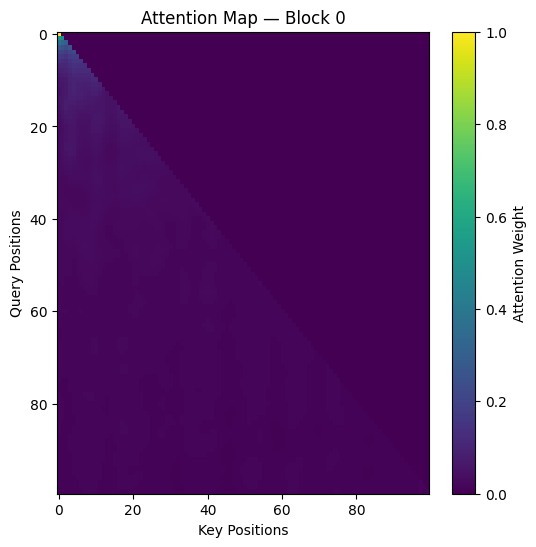

Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)


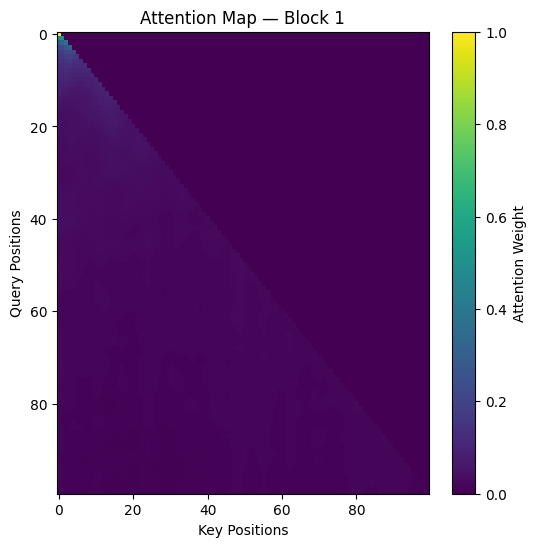

Loading: /content/drive/MyDrive/FI-2010/Train_Dst_NoAuction_ZScore_CF_8.txt
Feature matrix: (144, 310228) Label: (5, 310228)


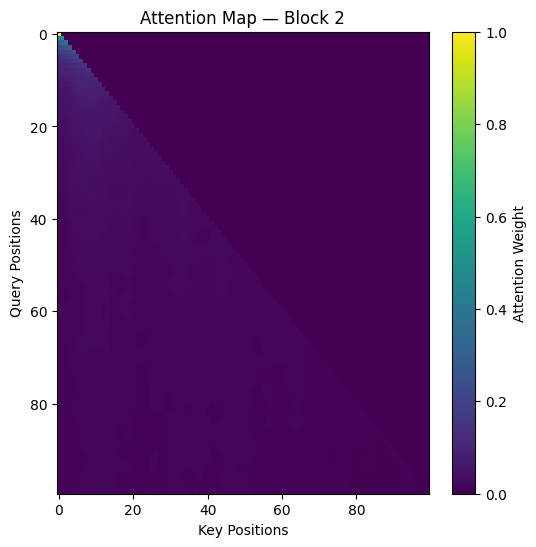

In [ ]:
visualize_attention(model, data_fold=8, block_idx=0)
visualize_attention(model, data_fold=8, block_idx=1)
visualize_attention(model, data_fold=8, block_idx=2)

=== Validation Metrics (CF8) === acc f1 bal_acc mcc Majority 0.450005 0.206898 0.333333 0.000000 LogReg 0.460200 0.444373 0.445067 0.167633 PureCNN 0.519418 0.466277 0.469617 0.233456 CNN+LSTM 0.695032 0.674255 0.668211 0.522639 LiteTrans_BASE 0.674164 0.646965 0.638929 0.488439 LiteTrans_FT 0.692840 0.671681 0.665318 0.518867 === Test Metrics (CF9) === acc f1 bal_acc mcc Majority 0.506015 0.223997 0.333333 0.000000 LogReg 0.446000 0.413386 0.415394 0.125107 PureCNN 0.510098 0.419183 0.422071 0.165902 CNN+LSTM 0.687471 0.644485 0.634333 0.484677 LiteTrans_BASE 0.667148 0.616715 0.603754 0.446434 LiteTrans_FT 0.679053 0.635993 0.625948 0.470478 === Efficiency === params latency_ms PureCNN 66883.0 0.344872 CNN+LSTM 79331.0 0.634956 Lite_BASE 107331.0 3.062582 Lite_FT 107331.0 3.043795 Enhanced LiteTransLOB - Validation (CF8): {'acc': np.float64(0.6975248929474281), 'f1': 0.6760846615812017, 'bal_acc': np.float64(0.6688562788649147), 'mcc': np.float64(0.5260145204312545)} Enhanced LiteTransLOB - Test (CF9): {'acc': np.float64(0.67848729465716), 'f1': 0.6340384639925379, 'bal_acc': np.float64(0.6224105965465955), 'mcc': np.float64(0.4679977864654013)} Multi-model × Single-horizon benchmark (Only H50) Benchmark Results: model horizon label_row best_val_acc_during_train val_acc val_f1 val_bal_acc val_mcc test_acc test_f1 test_bal_acc test_mcc params 0 CNNLSTM H50 2 0.689232 0.689232 0.667719 0.661446 0.513062 0.681126 0.635134 0.625125 0.473702 79331 1 LiteTrans_FT H50 2 0.696448 0.696448 0.672430 0.664013 0.523997 0.684078 0.633670 0.619513 0.475664 107331 2 EnhancedLiteTrans H50 2 0.700585 0.700585 0.677131 0.667811 0.530498 0.684173 0.635370 0.620612 0.475444 294147 ===== Ablation (H50) Results ===== name params val_acc val_f1 val_bal_acc val_mcc test_acc test_f1 test_bal_acc test_mcc 0 NoConvStem 76547 0.458033 0.306552 0.367300 0.087038 0.512768 0.307248 0.364470 0.098998 1 NoPosEncoding 107331 0.450133 0.344170 0.376321 0.090238 0.485850 0.353472 0.378906 0.099725 === Running Efficiency Test: CNNLSTM === === Running Efficiency Test: LiteTrans_FT === === Running Efficiency Test: EnhancedLiteTrans === ===== Efficiency Benchmark Results ===== model params avg_forward_time_sec 0 CNNLSTM 79331 0.000590 1 LiteTrans_FT 107331 0.002245 2 EnhancedLiteTrans 294147 0.003147 Ablation Block 1: EnhancedLiteTransLOB (No Scheduler): [NoScheduler] Best Val Acc = 0.687142 Ablation Block 2: EnhancedLiteTransLOB with layers=2 (Reduced Depth): Best validation accuracy (scheduler training): 0.672532